In [1]:
import os, sys, json
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)

import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from collections import defaultdict
from tabulate import tabulate
from IPython.core.display import display, HTML

# Increase display width
display(HTML("<style>.container { width:80% !important; }</style>"))

# Some styling
plt.style.use('ggplot')
# plt.rcParams['figure.figsize'] = 10, 10

In [2]:
# We reuse these over and over and it's easier to have them in a list than unordered dict
model_names = ["wgan", "wgpgan", "nsgan", "mmgan", "ragan", 
               "lsgan", "dragan", "began", "infogan", "fishergan", 
               "fgan_forward_kl", "fgan_reverse_kl", "fgan_jensen_shannon",
               "fgan_total_var", "fgan_hellinger", "fgan_pearson"]
distance_metrics=["KL-Divergence", "Jensen-Shannon", "Wasserstein-Distance"]#, "Energy-Distance"]

# Colors
palette = ["#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c", "#98df8a", "#d62728", "#ff9896", "#9467bd",
            "#c5b0d5", "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f", "#c7c7c7", "#bcbd22" "#dbdb8d",
            "#17becf", "#9edae5"]


def graph_mnist(optimal, 
               omit_outliers=True,
               thresh=5,
               model_names=model_names,
               distance_metrics=distance_metrics,
               palette=palette):
    
    fig, axes = plt.subplots(1, 3, sharex=True, sharey=False, figsize=(20,10))

    for d_idx, metric in enumerate(distance_metrics):
        
        for idx, model_name in enumerate(model_names):

            if model_name in ['vae', 'autoencoder']:
                continue
            
            data = optimal[model_name]['mnist'][metric]['mean']
            
            if omit_outliers:
                # Remove outliers
                data = np.array(data)
                notnan_indexes = ~np.isnan(data)
                no_outliers = data.flatten()[~is_outlier(data[notnan_indexes], thresh=thresh)]

                axes[d_idx].plot(np.linspace(1, data.shape[0]+1, no_outliers.shape[0]),
                                 no_outliers,
                                 label=model_name,
                                 c=palette[idx])

            else:

                axes[d_idx].plot(range(1, len(data)+1),
                                 data,
                                 c=palette[idx],
                                 label=model_name)

        axes[d_idx].set_title("{0}".format(metric))
            
    fig.suptitle("{0}".format(metric), fontsize=18)
    fig.text(0.5, 0.04, "Epoch", ha='center', fontsize=16)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16)
    plt.show()
#     plt.savefig('../graphs/mnist/{0}_{1}_{2}.png'.format(metric, 0, 0), dpi=100)

            
def mean_confidence_interval(data, axis=1, confidence=0.95):
    try:
        n = data.shape[axis]
    except IndexError:
        axis = 0
        n = data.shape[axis]

    mu, std = np.nanmean(data, axis=axis), scipy.stats.sem(data, axis=axis, nan_policy='omit')
    h = np.ma.getdata(std) * scipy.stats.t.ppf((1 + confidence) / 2., n-1)       

    return mu, h, mu-h, mu+h


def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh


def nested_pickle_dict():
    """ Picklable defaultdict nested dictionaries """
    return defaultdict(nested_pickle_dict)


def load_best(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
        
    return data

In [3]:
optimal = load_best('/Users/sob/Desktop/gan_results/best_1024/mnist/0_dims_0_samples/data.json')

 Plot mean performance across epochs for MNIST 


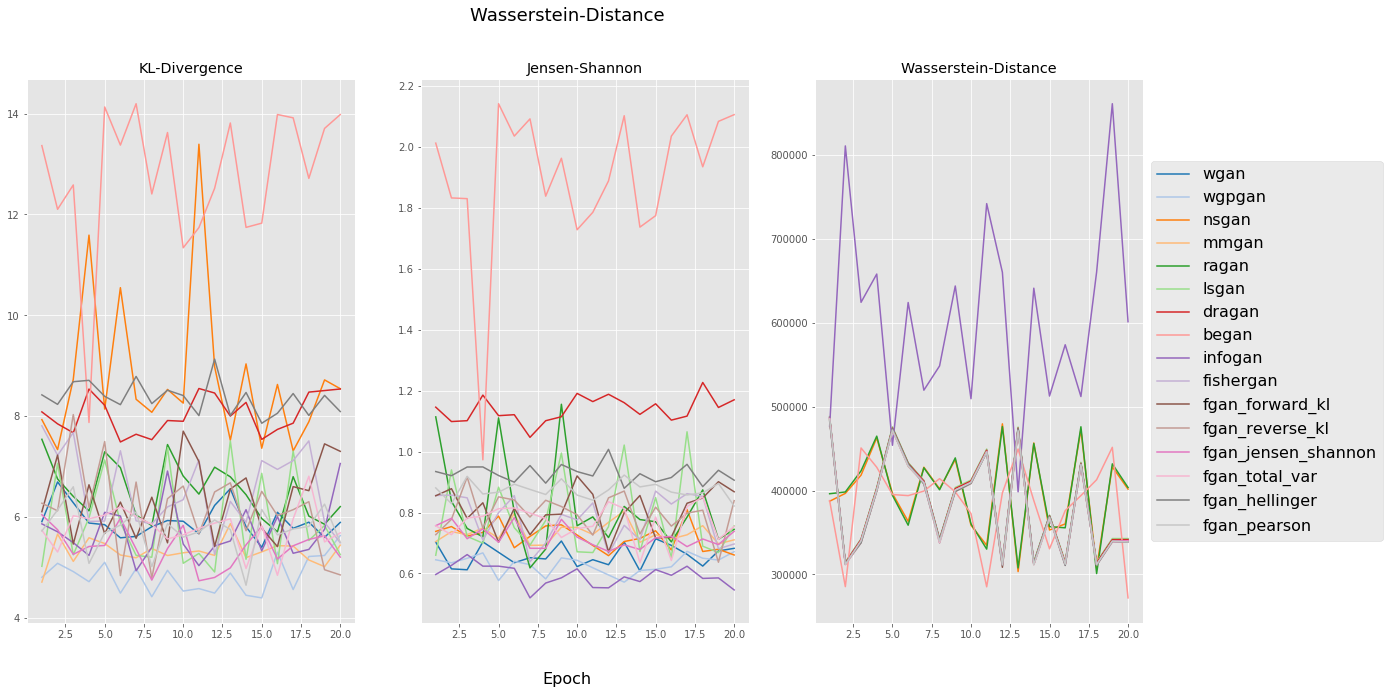

In [4]:
print(""" Plot mean performance across epochs for MNIST """)
graph_mnist(optimal, omit_outliers=False, thresh=2.5)

In [5]:
print(""" Print confidence intervals for minimum across all runs\n """)
rankings_dict = nested_pickle_dict()
param_dict = nested_pickle_dict()

for metric in distance_metrics:

    for model_name in model_names:

        minimums = np.nanmin(np.array(optimal[model_name]['mnist'][metric]['values']), axis=1)
        mu, h, low, high = mean_confidence_interval(minimums)
        param_dict[metric][model_name]['mnist'] = '%.3f ± %.3f' % (np.round(mu, 3), np.round(h, 3))

data = [[key, param_dict['KL-Divergence'][key]['mnist'], param_dict['Jensen-Shannon'][key]['mnist'],
              param_dict['Wasserstein-Distance'][key]['mnist']]
         for key in model_names]
print(tabulate(data, headers=['Model', 'KL-Divergence', 'Jensen-Shannon', 'Wasserstein-Distance']), '\n')

rankings = np.argsort([[eval(i[:4]) if i[:4] != 'nan ' else 1e10 for i in j[1:]] for j in data], axis=0)

 Print confidence intervals for minimum across all runs
 
Model                KL-Divergence    Jensen-Shannon    Wasserstein-Distance
-------------------  ---------------  ----------------  ----------------------
wgan                 4.259 ± 0.077    0.571 ± 0.012     383969.779 ± 28412.789
wgpgan               3.974 ± 0.046    0.376 ± 0.012     383937.132 ± 28404.833
nsgan                4.553 ± 0.149    0.458 ± 0.023     338329.023 ± 23046.263
mmgan                4.576 ± 0.123    0.601 ± 0.026     378646.887 ± 28229.324
ragan                4.922 ± 0.441    0.566 ± 0.081     345278.656 ± 26385.917
lsgan                4.786 ± 0.373    0.618 ± 0.061     383927.964 ± 28405.458
dragan               5.764 ± 0.298    0.868 ± 0.014     383941.206 ± 28401.277
began                5.696 ± 0.131    0.656 ± 0.016     329226.845 ± 22994.411
infogan              4.696 ± 0.214    0.444 ± 0.012     324175.002 ± 22242.122
fishergan            5.159 ± 0.291    0.687 ± 0.061     375998.978 ± 28413.

In [6]:
print(""" Get relative ranking performance based on mean minimum performance\n """)
print('0 is the best performance.\n')

print(tabulate([[key, rankings[idx, 0], rankings[idx, 1], rankings[idx, 2]]
                 for idx, key in enumerate(model_names)], 
               headers=['Model', 'KL-Divergence', 'Jensen-Shannon', 'Wasserstein-Distance']))

 Get relative ranking performance based on mean minimum performance
 
0 is the best performance.

Model                  KL-Divergence    Jensen-Shannon    Wasserstein-Distance
-------------------  ---------------  ----------------  ----------------------
wgan                               1                 1                       8
wgpgan                             0                 8                       7
nsgan                              2                 2                       2
mmgan                              3                 4                       4
ragan                              8                 0                      11
lsgan                             12                 3                      13
dragan                             5                 5                       9
began                              4                 7                      15
infogan                           14                12                      10
fishergan                        

 Plot mean minimum performance with error bars as a function of number samples 


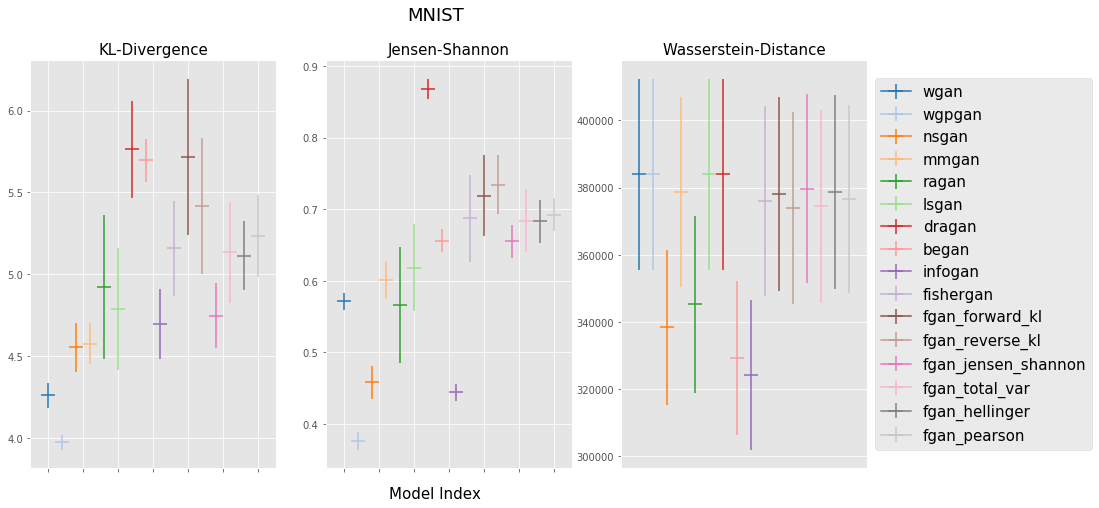

In [7]:
print(""" Plot mean minimum performance with error bars as a function of number samples """)

plt_idx = [(0,), (1,), (2,)]
fig, axes = plt.subplots(1, 3, sharex=True, sharey=False, figsize=(15,7.5))

for d_idx, metric in enumerate(distance_metrics):

    for idx, model_name in enumerate(model_names):

        x, y, yerr = [], [], []
        for key, val in param_dict[metric][model_name].items():
            if key == 'error':
                continue

            mu, err = val.split('±')
            x.append(idx), y.append(float(mu)), yerr.append(float(err))
        axes[plt_idx[d_idx][0]].errorbar(x, y, xerr=0.5, yerr=yerr,
                                                              barsabove=False, label=model_name,
                                                              c=palette[idx], ecolor=palette[idx])
    axes[plt_idx[d_idx][0]].set_title("{0}".format(metric), fontsize=15)
    axes[plt_idx[d_idx][0]].xaxis.set_ticklabels([])

fig.suptitle("{0}".format('MNIST'), fontsize=18)
fig.text(0.5, 0.07, "Model Index", ha='center', fontsize=15)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)
plt.gca().axes.get_xaxis().set_visible(False)
plt.show()

In [8]:
print(""" Get number of different hyperparameters for each minimum run\n """)
param_dict = nested_pickle_dict()

for metric in distance_metrics:
                                
    for model_name in model_names:
#         if 'hyperparams' not in param_dict[model_name][metric]:
#             param_dict[model_name][metric]['hyperparams'] = ''
        param_dict[model_name][metric]['params'] = ' '.join([str(i) for i in optimal[model_name]['mnist'][metric]['parameters']])

print(tabulate([[model_name, param_dict[model_name]['KL-Divergence']['params'], 
                             param_dict[model_name]['Jensen-Shannon']['params'], 
                             param_dict[model_name]['Wasserstein-Distance']['params']]
                 for model_name in model_names], 
               headers=['Model', 'KL-Divergence', 'Jensen-Shannon', 'Wasserstein-Distance'], tablefmt='fancy_grid'))

 Get number of different hyperparameters for each minimum run
 
╒═════════════════════╤══════════════════╤══════════════════╤════════════════════════╕
│ Model               │ KL-Divergence    │ Jensen-Shannon   │ Wasserstein-Distance   │
╞═════════════════════╪══════════════════╪══════════════════╪════════════════════════╡
│ wgan                │ 0.0025 512 1024  │ 0.025 32 1024    │ 0.00025 128 1024       │
├─────────────────────┼──────────────────┼──────────────────┼────────────────────────┤
│ wgpgan              │ 0.025 512 1024   │ 0.0025 512 1024  │ 0.00025 128 1024       │
├─────────────────────┼──────────────────┼──────────────────┼────────────────────────┤
│ nsgan               │ 0.0025 512 1024  │ 0.0025 128 1024  │ 0.00025 512 1024       │
├─────────────────────┼──────────────────┼──────────────────┼────────────────────────┤
│ mmgan               │ 0.0025 64 1024   │ 0.0025 64 1024   │ 0.00025 128 1024       │
├─────────────────────┼──────────────────┼──────────────────┼─────